# Representation Learning & Generative Learning with AutoEncoders, GANs, and Diffusion Models

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

# 1. UnderComplete Linear AutoEncoder (PCA)

In [3]:
cls()

encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.models.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss='mse', optimizer=optimizer)

In [4]:
# Lets build some random 3D dataset
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit
X_train.shape

(60, 3)

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=100, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 0s/step


Text(0.5, 0.92, '3D plot of original data')

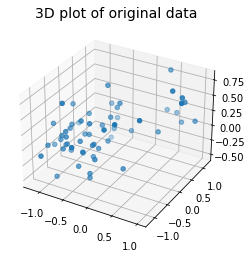

In [7]:
# This is 3D plot without interaction
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,1], X_train[:,0], X_train[:,2], 'gray')
ax.set_title("3D plot of original data")

<ipython-input-16-f437b98d56f8>:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


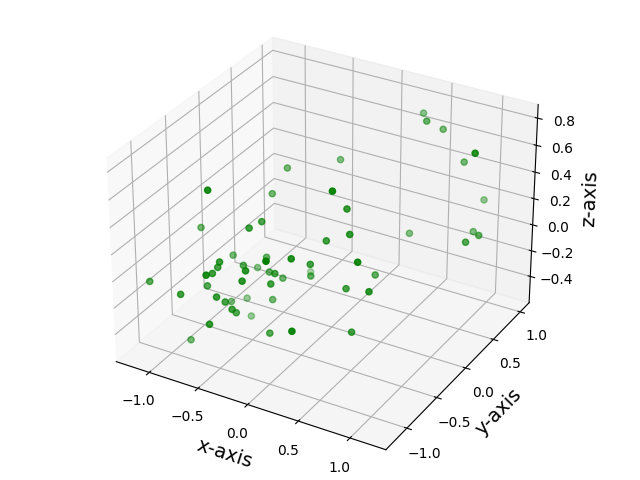

In [16]:
# 3D plot with interaction
import matplotlib
matplotlib.use("Agg")
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
xs = X_train[:,0]
ys = X_train[:,1]
zs = X_train[:,2]
fig = plt.figure()
ax = Axes3D(fig)
plot_geeks = ax.scatter(xs, ys, zs, color='green')
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

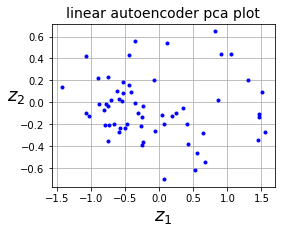

In [17]:
# This is 2D output that we got from decoder
%matplotlib inline
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title('linear autoencoder pca plot')
plt.show()

# 2. Stacked AutoEncoders

In [18]:
# lets load mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [23]:
X_train.shape

(55000, 28, 28)

In [24]:
stacked_encoder = tf.keras.models.Sequential([
                    tf.keras.layers.Flatten(), # Flatten the neuron
                    tf.keras.layers.Dense(50, activation='relu'), # 1st HL
                    tf.keras.layers.Dense(30, activation='relu'), # coding 
])
#You can consider this as an regression task where we do not use activation at last layer
stacked_decoder = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(28*28), # Linear layer or output layer
                    tf.keras.layers.Reshape([28,28])
])

stacked_auto_encoder = tf.keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_auto_encoder.compile(loss='mse', optimizer='nadam')
history = stacked_auto_encoder.fit(X_train,X_train, epochs=50, 
                    validation_data=(X_valid, X_valid), verbose=False)


### A. Visualizing the Reconstructions
The output of Decoder is called reconstruction

1/1 [==============================] - 0s 19ms/step


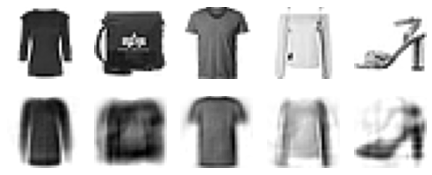

In [28]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_auto_encoder)
plt.show()

In [30]:
# You can see Images compressed down to 30 neuron and try
# to regain its original details of 784 neurons

### B. Visualizing cluster of data

In [31]:
# Lets visualize how image look like in 2D cluster

In [37]:
from sklearn.manifold import TSNE

x_valid_compressed = stacked_encoder.predict(X_valid) # Will give [Batch, 30] dim output
print("Dimension of X_valid compressed : ", x_valid_compressed.shape)
# Now we use another dimention reduction technique to
# visualize this data into 2D
tsne = TSNE(init="pca")
x_valid_2D = tsne.fit_transform(np.asarray(x_valid_compressed, dtype='uint8'))

157/157 [==============================] - 0s 1ms/step
Dimension of X_valid compressed :  (5000, 30)


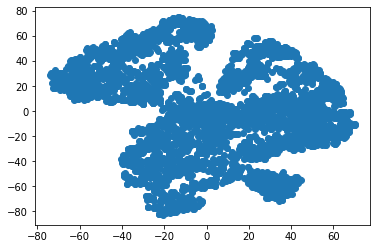

In [42]:
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1])
plt.show()

In [43]:
np.unique(y_valid)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

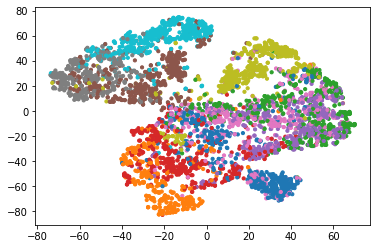

In [45]:
# There would be around 10 clusters
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1], 
            c=y_valid, s=10, cmap="tab10")
plt.show()

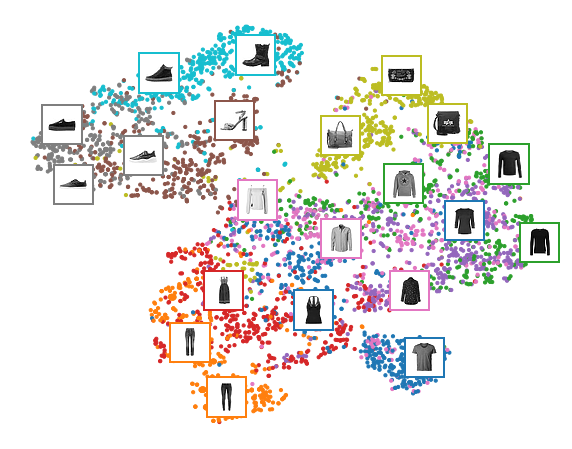

In [47]:
# Visualizing the Fashion MNIST

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = x_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), 
            "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

# 3. Tying Weights
It's a technique by which we can tie to weight of encoder layer
with the decoder so. So it helps to reduce to quantity of total
parameters.

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [53]:
cls()

class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                    shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape) # must call at last

    def call(self, X):
        # Instead of multipling with new weights
        # we use previous layers weights
        Z = tf.matmul(X, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [88]:
cls()

# Lets creates layers seperately bcz we will use them to tie
# with decoder
dense_1 = tf.keras.layers.Dense(100,activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')

tied_encoder = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                dense_1,
                dense_2
])

tied_decoder = tf.keras.models.Sequential([
                DenseTranspose(dense_2, activation='relu'),
                DenseTranspose(dense_1),
                tf.keras.layers.Reshape([28,28])
])
tied_autoencoder = tf.keras.models.Sequential([tied_encoder,tied_decoder])
tied_autoencoder.compile(loss="mse", optimizer="nadam")
history = tied_autoencoder.fit(X_train, X_train, epochs=2,
                validation_data=(X_valid, X_valid), verbose=False)

In [92]:
dense_2.weights[1].shape

TensorShape([30])

In [93]:
for layers in tied_encoder.get_weights():
    print(layers.shape)

(784, 100)
(100,)
(100, 30)
(30,)


In [94]:
tied_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [95]:
tied_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_transpose (DenseTrans  (None, 100)              3130      
 pose)                                                           
                                                                 
 dense_transpose_1 (DenseTra  (None, 784)              79284     
 nspose)                                                         
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [96]:
for layers in tied_decoder.get_weights():
    print(layers.shape)

(100,)
(100, 30)
(30,)
(784,)
(784, 100)
(100,)


1/1 [==============================] - 0s 75ms/step


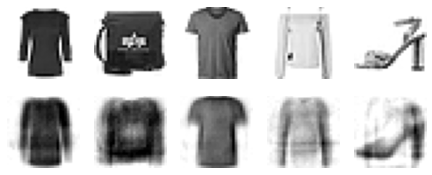

In [97]:
plot_reconstructions(tied_autoencoder)

# 4. Training one AutoEncoder at a Time

In [100]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=5,
                      output_activation=None, verbose=False):
    n_inputs = X_train.shape[-1] # 28
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid), verbose=verbose)
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [101]:
cls()

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
# Train Auto-Encoder with one HL have 50 neuron
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    50, X_train_flat, X_valid_flat)

# Train Auto-Encoder with one HL 30 neuron
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

In [102]:
# Putting all Together
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 26ms/step


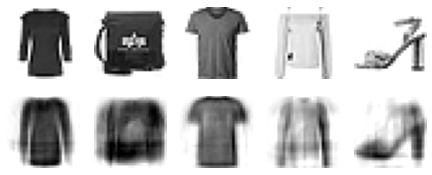

In [107]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [104]:
# We can also train full auto-encoder for few epoch.
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=1,
                        validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 6s 3ms/step - loss: 0.0168 - val_loss: 0.0158


1/1 [==============================] - 0s 39ms/step


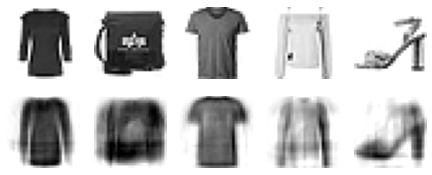

In [106]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

# 5. Convolutional Autoencoders